# Explore here

In [55]:
import pandas as pd 
import re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from pickle import dump

In [2]:
#EXPORTAR DATOS 
df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
df.head()
df.columns

Index(['url', 'is_spam'], dtype='object')

In [3]:
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
#CAMBIO TRUE=1, FALSE=0
df["is_spam"]= df["is_spam"].astype(int)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [5]:
df.dtypes
df["url"].isna().sum()


np.int64(0)

In [6]:
df["url"].astype(str)

0       https://briefingday.us8.list-manage.com/unsubs...
1                                  https://www.hvper.com/
2                      https://briefingday.com/m/v4n3i4f3
3        https://briefingday.com/n/20200618/m#commentform
4                             https://briefingday.com/fan
                              ...                        
2994    https://www.smartcitiesworld.net/news/news/dee...
2995                        https://www.youtube.com/watch
2996    https://techcrunch.com/2019/07/04/an-optimisti...
2997    https://www.technologyreview.com/2019/12/20/13...
2998         https://www.bbc.com/news/technology-51018758
Name: url, Length: 2999, dtype: object

In [15]:

def preprocess_text(text):
  
    text = re.sub(r'[^a-z ]', " ", text)
    
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    text = re.sub(r'\s+', " ", text.lower())

    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

df["processed_words"] = [preprocess_text(text) for text in df['url']]
df.head()

,url,is_spam,processed_words
0,https://briefingday.us8.list-manage.com/unsubs...,1,"[https, briefingday, us, list, manage, com, un..."
1,https://www.hvper.com/,1,"[https, www, hvper, com]"
2,https://briefingday.com/m/v4n3i4f3,1,"[https, briefingday, com, v, i]"
3,https://briefingday.com/n/20200618/m#commentform,0,"[https, briefingday, com, m, commentform]"
4,https://briefingday.com/fan,1,"[https, briefingday, com, fan]"


He tenido que hacer una nueva columna paras las palabras procesadas porque hacer la modificación en la misma me daba fallo 

In [8]:
df = df.drop_duplicates()
df = df.reset_index(inplace = False, drop = True)
df.shape

(2369, 3)

In [11]:
conteo=df["is_spam"].value_counts()
spam= conteo[0]
no_spam=conteo[1]
print(f"Hay {spam} urls con contenido spam y {no_spam} urls con contenido no spam")

Hay 2125 urls con contenido spam y 244 urls con contenido no spam


In [16]:
#LEMATIZACIÓN, ELIMINACIÓN DE STOPWORDS Y NETWORDS

download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

df["processed_words"] = df["processed_words"].apply(lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to /home/gitpod/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam,processed_words
0,https://briefingday.us8.list-manage.com/unsubs...,1,"[http, briefingday, list, manage, unsubscribe]"
1,https://www.hvper.com/,1,"[http, hvper]"
2,https://briefingday.com/m/v4n3i4f3,1,"[http, briefingday]"
3,https://briefingday.com/n/20200618/m#commentform,0,"[http, briefingday, commentform]"
4,https://briefingday.com/fan,1,"[http, briefingday]"


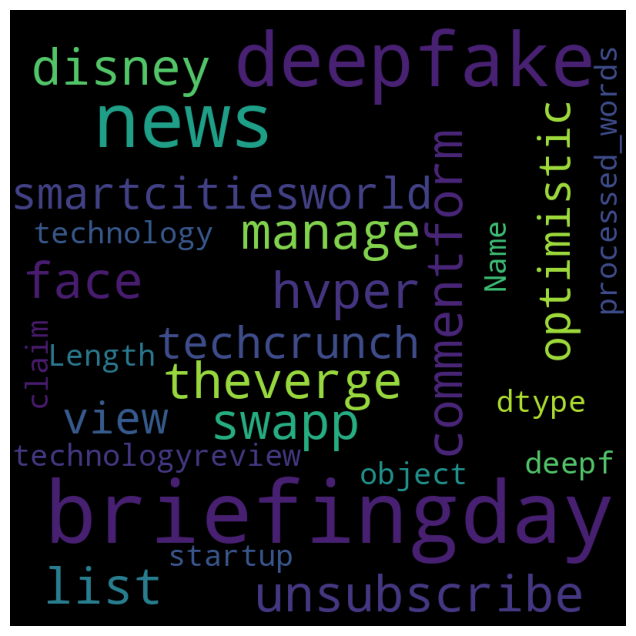

In [24]:
#VISUALIZACION DE LOS TOKENS EN NUBE DE IMAGENES 

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(df["processed_words"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [26]:
#PASAR LAS PALABRAS A NÚMEROS SEGÚN PESO 

tokens_list = df["processed_words"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)

#DIVIDIR EN X (PALABRAS) E Y (SPAM/NO SPAM)
X = vectorizer.fit_transform(tokens_list).toarray()
y = df["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
#TRAIN Y TEST

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape

(1895, 538)


In [46]:
X_test.shape

(474, 538)

In [50]:
print(type(X_train)), print(type(y_train))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


(None, None)

In [42]:
#MODELO CLASIFICADOR
modelo = SVC(kernel = "linear", random_state = 42)
modelo.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

In [43]:
#EXACTITUD MODELO
y_pred = modelo.predict(X_test)
y_pred

accuracy_score(y_pred, y_test)

0.9514767932489452

La accuracy es bastante buena, pero voy a hacer una optimización de hiperparamteros por GridSearchCV. Pero aquí me surje la duda de que sí siempre hay que optimizar los hiperparametros aunque tengas un valor de accurancy >0.95

In [53]:
#OPTIMIZACIÓN

hiperparametros = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],"kernel": ["linear", "poly", "rbf", "sigmoid"],"degree": [1, 2, 3, 4, 5],"gamma": ["scale", "auto"]}

grid = GridSearchCV(modelo, hiperparametros, scoring = "accuracy", cv = 5)
grid.fit(X_train, y_train)

print(f"Los mejores hiperparámetros: {grid.best_params_}")

Los mejores hiperparámetros: {'C': 1000, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}


In [54]:
opt_modelo = SVC(C = 1000, degree = 1, gamma = "auto", kernel = "poly", random_state = 42)
opt_modelo.fit(X_train, y_train)
y_pred = opt_modelo.predict(X_test)
accuracy_score(y_test, y_pred)

0.9620253164556962

Ha mejorado la accuracy con los nuevos hiperparámetros

In [57]:
dump(modelo, open("/workspace/NLP/models/modelo_opti", "wb"))